# Buck Converter Simulation

This notebook demonstrates buck converter analysis with Pulsim.

## Contents
1. Circuit Description & Theory
2. Building the Circuit
3. DC Analysis
4. Transient Analysis (LC Filter Response)
5. Design Calculations

## 1. Circuit Description

A buck converter steps down voltage from Vin to Vout.

```
        SW (main)
Vin ──┬──/  /──┬──LLLL──┬── Vout
      │        │   L    │
      │    D   │        ═ C
      │   ─┬─  │        │
GND ──┴────┴───┴────────┴── GND
```

**Key Equations:**
- Output voltage: Vout = D × Vin
- Duty cycle: D = Vout / Vin
- Inductor ripple: ΔI_L = (Vin - Vout) × D × T / L
- Voltage ripple: ΔV_out ≈ ΔI_L / (8 × f_sw × C)

In [1]:
from pathlib import Path
import sys

_root = Path.cwd()
_candidate_paths = []
for _ in range(6):
    for _rel in (('build-test', 'python'), ('build', 'python')):
        candidate = _root / _rel[0] / _rel[1]
        if candidate.is_dir():
            _candidate_paths.append(candidate)
    _root = _root.parent

_unique_candidates = []
_seen = set()
for candidate in _candidate_paths:
    cstr = str(candidate)
    if cstr in _seen:
        continue
    _seen.add(cstr)
    _unique_candidates.append(candidate)

_bootstrap_error = None
for candidate in _unique_candidates:
    cstr = str(candidate)
    if cstr not in sys.path:
        sys.path.insert(0, cstr)
    try:
        import pulsim  # noqa: F401
        break
    except Exception as exc:
        _bootstrap_error = exc
        if cstr in sys.path:
            sys.path.remove(cstr)
else:
    if _bootstrap_error is not None:
        raise _bootstrap_error

import pulsim as ps
import numpy as np
import matplotlib.pyplot as plt

# Design parameters
VIN = 12.0       # Input voltage (V)
VOUT = 5.0       # Target output voltage (V)
FSW = 100e3      # Switching frequency (Hz)
L = 100e-6       # Inductance (H)
C = 100e-6       # Capacitance (F)
R_LOAD = 2.5     # Load resistance (Ω) -> 2A @ 5V

# Calculated parameters
D = VOUT / VIN
T_SW = 1 / FSW
I_OUT = VOUT / R_LOAD

print("Buck Converter Design:")
print(f"  Input voltage:  {VIN} V")
print(f"  Output voltage: {VOUT} V")
print(f"  Duty cycle:     {D:.3f} ({D*100:.1f}%)")
print(f"  Output current: {I_OUT} A")
print(f"  Switching freq: {FSW/1e3} kHz")
print(f"  Switch period:  {T_SW*1e6:.1f} µs")

Buck Converter Design:
  Input voltage:  12.0 V
  Output voltage: 5.0 V
  Duty cycle:     0.417 (41.7%)
  Output current: 2.0 A
  Switching freq: 100.0 kHz
  Switch period:  10.0 µs


## 2. Building the Circuit

We'll build a simplified buck converter with:
- IdealSwitch for the main switch
- IdealDiode for freewheeling
- LC output filter
- Resistive load

In [2]:
def build_buck_converter():
    """Build buck converter circuit."""
    ckt = ps.Circuit()
    gnd = ckt.ground()  # Ground reference
    
    # Nodes
    n_vin = ckt.add_node("vin")      # Input
    n_sw = ckt.add_node("sw_node")   # Switch node
    n_out = ckt.add_node("vout")     # Output
    
    # Input voltage
    ckt.add_voltage_source("Vin", n_vin, gnd, VIN)
    
    # Main switch (start closed to analyze DC)
    ckt.add_switch("SW", n_vin, n_sw, closed=True)
    
    # Freewheeling diode
    ckt.add_diode("D1", gnd, n_sw)
    
    # LC filter
    ckt.add_inductor("L1", n_sw, n_out, L)
    ckt.add_capacitor("C1", n_out, gnd, C)
    
    # Load
    ckt.add_resistor("R_load", n_out, gnd, R_LOAD)
    
    return ckt

ckt = build_buck_converter()
print(f"Circuit built: {ckt.num_nodes()} nodes, system size {ckt.system_size()}")

Circuit built: 3 nodes, system size 5


## 3. DC Analysis

With switch always closed, DC steady state gives Vout = Vin (no switching).

In [3]:
# DC operating point
dc_result = ps.dc_operating_point(ckt)

print("DC Analysis (switch closed):")
print(f"  Success: {dc_result.success}")
print(f"  V_in = {dc_result.newton_result.solution[0]:.4f} V")
print(f"  V_sw = {dc_result.newton_result.solution[1]:.4f} V")
print(f"  V_out = {dc_result.newton_result.solution[2]:.4f} V")
print()
print("Note: With switch always ON, Vout = Vin (no voltage step-down)")
print("Real buck operation requires PWM switching.")

DC Analysis (switch closed):
  Success: True
  V_in = 12.0000 V
  V_sw = 12.0000 V
  V_out = 12.0000 V

Note: With switch always ON, Vout = Vin (no voltage step-down)
Real buck operation requires PWM switching.


## 4. Transient Analysis

Let's analyze the LC filter transient response.

### 4.1 Startup Transient (Capacitor Charging)

In [4]:
# LC filter time constant
f_resonant = 1 / (2 * np.pi * np.sqrt(L * C))
T_LC = 1 / f_resonant

print(f"LC Filter Characteristics:")
print(f"  Resonant frequency: {f_resonant:.1f} Hz")
print(f"  LC period: {T_LC*1000:.2f} ms")
print(f"  f_sw / f_LC = {FSW / f_resonant:.1f}")

LC Filter Characteristics:
  Resonant frequency: 1591.5 Hz
  LC period: 0.63 ms
  f_sw / f_LC = 62.8


In [5]:
# Startup simulation - capacitor charging through LC filter
# Initial condition: capacitor discharged
x0 = np.zeros(ckt.system_size())
x0[0] = VIN    # V_in
x0[1] = VIN    # V_sw (switch closed)
x0[2] = 0.0    # V_out (capacitor discharged)

# Simulate for multiple LC periods
t_stop = 5 * T_LC
dt = T_LC / 100

times, states, success, msg = ps.run_transient(ckt, 0.0, t_stop, dt, x0)

print(f"Startup Transient:")
print(f"  Success: {success}")
print(f"  Duration: {t_stop*1000:.2f} ms")
print(f"  Points: {len(times)}")

Startup Transient:
  Success: True
  Duration: 3.14 ms
  Points: 501


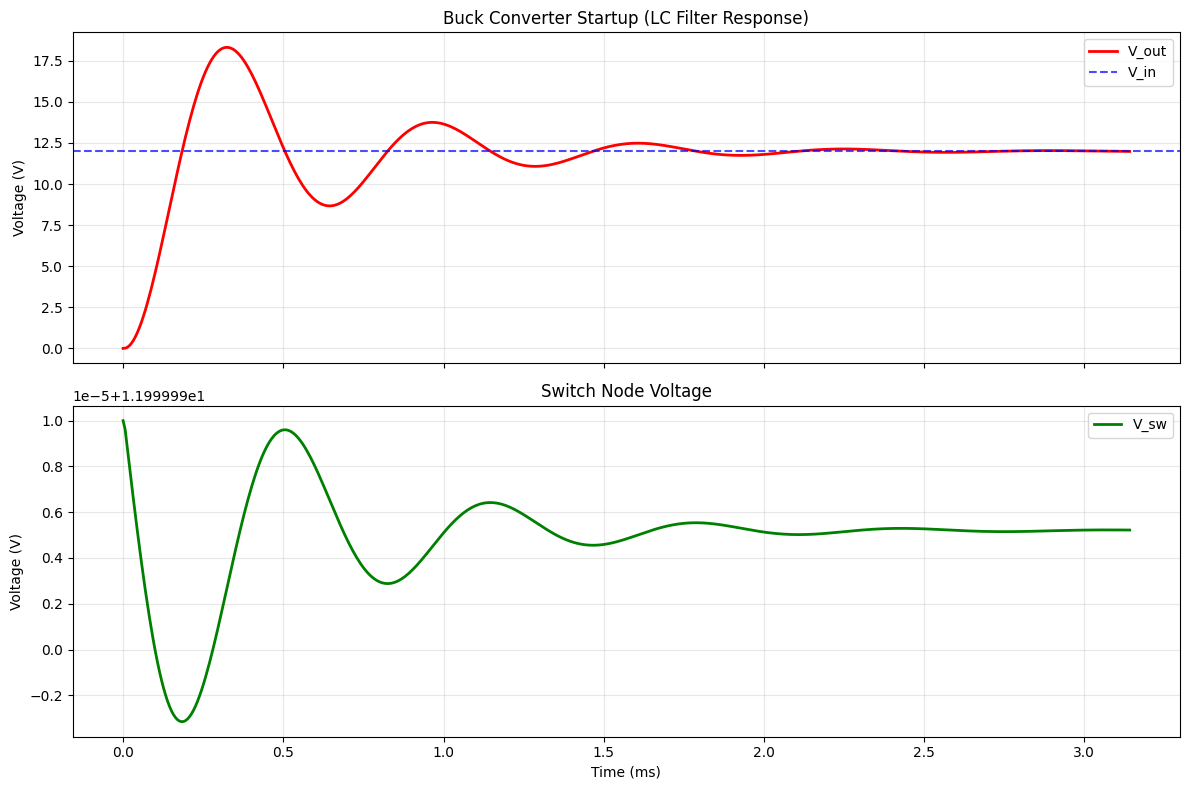


Startup Analysis:
  V_out initial: 0.00 V
  V_out peak: 18.32 V
  V_out final: 11.99 V
  Overshoot: 52.6%


In [6]:
# Extract results
times = np.array(times)
v_in = np.array([s[0] for s in states])
v_sw = np.array([s[1] for s in states])
v_out = np.array([s[2] for s in states])

# Plot startup transient
fig, axes = plt.subplots(2, 1, figsize=(12, 8), sharex=True)

# Output voltage
axes[0].plot(times*1000, v_out, 'r-', linewidth=2, label='V_out')
axes[0].axhline(y=VIN, color='b', linestyle='--', alpha=0.7, label='V_in')
axes[0].set_ylabel('Voltage (V)')
axes[0].set_title('Buck Converter Startup (LC Filter Response)')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# Switch node
axes[1].plot(times*1000, v_sw, 'g-', linewidth=2, label='V_sw')
axes[1].set_ylabel('Voltage (V)')
axes[1].set_xlabel('Time (ms)')
axes[1].set_title('Switch Node Voltage')
axes[1].legend()
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print(f"\nStartup Analysis:")
print(f"  V_out initial: {v_out[0]:.2f} V")
print(f"  V_out peak: {np.max(v_out):.2f} V")
print(f"  V_out final: {v_out[-1]:.2f} V")
print(f"  Overshoot: {(np.max(v_out)/VIN - 1)*100:.1f}%")

### 4.2 Pre-charged Capacitor Response

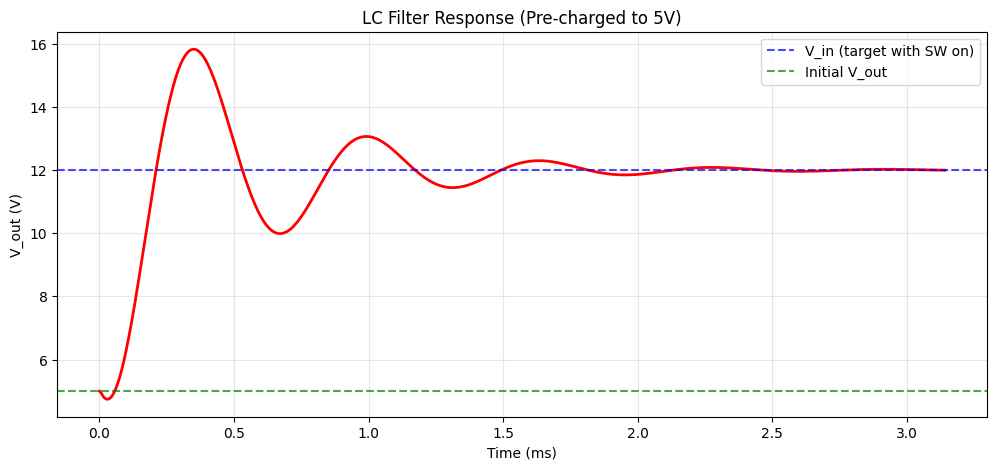

Pre-charged Response:
  Initial: 5.00 V
  Average: 11.83 V


In [7]:
# Start with capacitor pre-charged to target voltage
x0_precharged = np.zeros(ckt.system_size())
x0_precharged[0] = VIN
x0_precharged[1] = VIN
x0_precharged[2] = VOUT  # Pre-charged to 5V

times2, states2, success2, msg2 = ps.run_transient(ckt, 0.0, t_stop, dt, x0_precharged)

times2 = np.array(times2)
v_out2 = np.array([s[2] for s in states2])

# Plot
plt.figure(figsize=(12, 5))
plt.plot(times2*1000, v_out2, 'r-', linewidth=2)
plt.axhline(y=VIN, color='b', linestyle='--', alpha=0.7, label='V_in (target with SW on)')
plt.axhline(y=VOUT, color='g', linestyle='--', alpha=0.7, label='Initial V_out')
plt.xlabel('Time (ms)')
plt.ylabel('V_out (V)')
plt.title('LC Filter Response (Pre-charged to 5V)')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

print(f"Pre-charged Response:")
print(f"  Initial: {v_out2[0]:.2f} V")
print(f"  Average: {np.mean(v_out2):.2f} V")

## 5. Design Calculations

Let's verify the theoretical design equations.

In [8]:
print("Buck Converter Design Equations:")
print("="*50)

# Duty cycle
print(f"\n1. Duty Cycle")
print(f"   D = Vout / Vin = {VOUT} / {VIN} = {D:.4f}")

# Inductor ripple current
delta_IL = (VIN - VOUT) * D * T_SW / L
print(f"\n2. Inductor Ripple Current")
print(f"   ΔI_L = (Vin - Vout) × D × T / L")
print(f"   ΔI_L = ({VIN} - {VOUT}) × {D:.3f} × {T_SW*1e6:.1f}µs / {L*1e6:.0f}µH")
print(f"   ΔI_L = {delta_IL*1000:.2f} mA")

# Output voltage ripple
delta_Vout = delta_IL / (8 * FSW * C)
print(f"\n3. Output Voltage Ripple")
print(f"   ΔV_out = ΔI_L / (8 × f_sw × C)")
print(f"   ΔV_out = {delta_IL*1000:.2f}mA / (8 × {FSW/1e3:.0f}kHz × {C*1e6:.0f}µF)")
print(f"   ΔV_out = {delta_Vout*1000:.4f} mV")
print(f"   Ripple % = {delta_Vout/VOUT*100:.4f}%")

# Critical inductance (CCM/DCM boundary)
L_crit = (VIN - VOUT) * D / (2 * FSW * I_OUT)
print(f"\n4. Critical Inductance (CCM Boundary)")
print(f"   L_crit = (Vin - Vout) × D / (2 × f_sw × I_out)")
print(f"   L_crit = {L_crit*1e6:.2f} µH")
print(f"   L / L_crit = {L/L_crit:.1f}× (operating in {'CCM' if L > L_crit else 'DCM'})")

Buck Converter Design Equations:

1. Duty Cycle
   D = Vout / Vin = 5.0 / 12.0 = 0.4167

2. Inductor Ripple Current
   ΔI_L = (Vin - Vout) × D × T / L
   ΔI_L = (12.0 - 5.0) × 0.417 × 10.0µs / 100µH
   ΔI_L = 291.67 mA

3. Output Voltage Ripple
   ΔV_out = ΔI_L / (8 × f_sw × C)
   ΔV_out = 291.67mA / (8 × 100kHz × 100µF)
   ΔV_out = 3.6458 mV
   Ripple % = 0.0729%

4. Critical Inductance (CCM Boundary)
   L_crit = (Vin - Vout) × D / (2 × f_sw × I_out)
   L_crit = 7.29 µH
   L / L_crit = 13.7× (operating in CCM)


In [9]:
# Power calculations
print("\n5. Power Analysis")
print(f"   Output power: P_out = Vout² / R_load = {VOUT**2 / R_LOAD:.2f} W")
print(f"   Output current: I_out = Vout / R_load = {I_OUT:.2f} A")
print(f"   Input power (ideal): P_in = P_out / η ≈ {VOUT**2 / R_LOAD:.2f} W")
print(f"   Average input current: I_in = D × I_out = {D * I_OUT:.3f} A")


5. Power Analysis
   Output power: P_out = Vout² / R_load = 10.00 W
   Output current: I_out = Vout / R_load = 2.00 A
   Input power (ideal): P_in = P_out / η ≈ 10.00 W
   Average input current: I_in = D × I_out = 0.833 A


## Summary

In this notebook, we:
- Built a simplified buck converter model
- Analyzed DC operating point
- Simulated LC filter transient response
- Verified theoretical design equations

**Note:** Full PWM-controlled simulation would require implementing a callback mechanism to control switch states during the transient simulation. The current analysis demonstrates the LC filter behavior and design calculations.

**Next:** [Thermal Modeling Tutorial](03_thermal_modeling.ipynb)